# **SARS-CoV-2 conformational exploration**

This notebook is dedicated to the exploration of a simulation of the trajectory of the virus SARS-CoV-2. The data can be downloaded here https://figshare.com/articles/6_molecular_dynamics_simulations_of_coronavirus_2019-nCoV_protease_model_in_complex_with_different_conformations_of_lopinavir_/11764158. 

This script is meant to recover the results for detecting the conformational changes of SARS-CoV-2.

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from MDAnalysis import Universe

colors = ["tealish", "golden rod", "cranberry"]

sns.set(style='whitegrid', context='talk',
        font_scale=1, rc={"lines.linewidth": 2})
sns.set_palette(sns.xkcd_palette(colors))

## Importing trajectory

In [2]:
pathtraj = "./11764158/QHD_LP1/QHD_LP1/"

In [3]:
universe = Universe(pathtraj+'QHD_LP1.gro', pathtraj+'QHD_LP1.xtc')

In [4]:
print(universe.trajectory)

<XTCReader /home/amelie/Documents/LightOnProjects/lightongit/DiffusionMapsToy/datasets/11764158/QHD_LP1/QHD_LP1/QHD_LP1.xtc with 30004 frames of 4776 atoms>


In [5]:
all_atoms = universe.select_atoms("all")

In [6]:
coords = np.asarray([all_atoms.positions for frame in universe.trajectory], dtype='f8')
traj = coords.reshape(coords.shape[0], -1)

In [7]:
timerangeopu = np.arange(0, traj.shape[0])

## Analysis of NEWMA's results

In [8]:
# Import the data generated with the script newma_coronavirus.py
newma = np.load('newmaopu_corona_natoms_4776.npz')
detectopu = newma['detection_stat']
thopu = newma['online_th']

In [9]:
def changeconf(detectstat, th):
    '''
    This functions detects change points using NEWMA detection statistic and threshold. 
    
    Parameters 
    ----------
    detectstat: ndarray,
        detection statistic obtain with NEWMA
    th: ndarray, 
        detection threshold obtained with NEWMA
        
    Returns
    ----------
    args: ndarray, 
        array containing the points at which the detection stat is above the threshold for a significant amount of time.
    '''
    args = []
    k = 0
    m = 100
    while k < len(detectstat) - (m + 1):
        if (detectstat[k] >  th[k]):
            flag = True
            for n in range(1, m):
                if (detectstat[k + n] < th[k + n]):
                    flag = False
                    k = k + n + 1
                    break
            if flag:
                args.extend([k + n for n in range(0, m)])
                k = k + m + 1
        else:
            k = k + 1
    return args

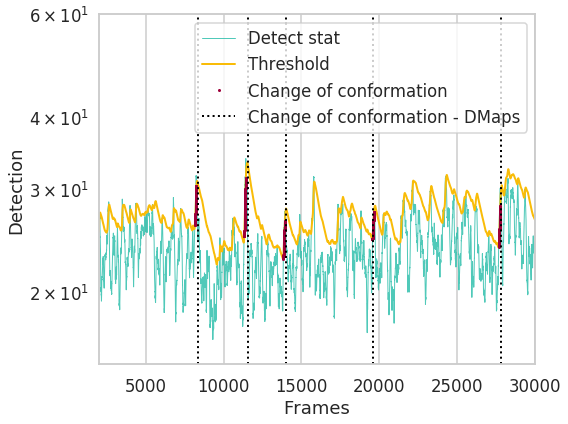

In [10]:
# compute performance metrics
argopuall = changeconf(detectopu, thopu)


fig, ax = plt.subplots(figsize=(8,6))

ax.semilogy(timerangeopu, detectopu,  label='Detect stat',
               alpha=0.8, linewidth=1)
ax.semilogy(timerangeopu, thopu, label='Threshold')
ax.semilogy(timerangeopu[argopuall], thopu[argopuall], "o", markersize=2, \
                                                             label='Change of '
                                                           'conformation')

# These change points were obtained using the diffusion map method of Trstanova and al. 2019
ax.axvline(x=8363, color='black', linestyle='dotted', label='Change of conformation - DMaps')
ax.axvline(x=11601, color='black', linestyle='dotted')
ax.axvline(x=14001, color='black', linestyle='dotted')
ax.axvline(x=19562, color='black', linestyle='dotted')
ax.axvline(x=27783, color='black', linestyle='dotted')


ax.set_xlabel('Frames')
ax.set_ylabel('Detection')
ax.set_xlim(2000, 30000)
ax.set_ylim(15, 60)
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('corona_newmadetec_fulltraj.png', format='png')